# Parallel Execution

In [1]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = False  # <-- TOGGLE THIS

if USE_LOCAL_SOURCE:
    import sys
    from pathlib import Path
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"📁 LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("📦 PIP PACKAGE MODE: Loading installed ras-commander")

# Import ras-commander
from ras_commander import RasCmdr, RasExamples, RasPrj, init_ras_project, ras

# Additional imports
import numpy as np
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
import psutil  # For getting system CPU info
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import subprocess
import shutil
import math  # Import math to avoid NameError in get_optimal_worker_count function

# Verify which version loaded
import ras_commander
print(f"✓ Loaded: {ras_commander.__file__}")

📦 PIP PACKAGE MODE: Loading installed ras-commander


2025-12-30 13:08:16 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


✓ Loaded: C:\GH\ras-commander\ras_commander\__init__.py


## Prerequisites

Before running this notebook, ensure you have:

1. **ras-commander installed**: `pip install ras-commander`
2. **Python 3.10+**: Check with `python --version`
3. **HEC-RAS 6.3+**: **REQUIRED** for plan execution
4. **Disk Space**: ~5 GB (multiple worker folders + results)
5. **CPU Cores**: 4+ recommended for meaningful parallelization

### What You'll Learn

This notebook demonstrates **parallel plan execution** using `RasCmdr.compute_parallel()`:

- **Worker Folders**: How ras-commander creates isolated execution environments
- **Concurrent Execution**: Run multiple plans simultaneously
- **Dynamic Worker Allocation**: Automatically scale to available CPU cores
- **Performance Comparison**: Measure speedup vs sequential execution

### Related Notebooks

- **110_single_plan_execution.ipynb** - Single plan fundamentals
- **111_executing_plan_sets.ipynb** - Sequential plan sets
- **112_sequential_plan_execution.ipynb** - Test mode for debugging
- **102_multiple_project_operations.ipynb** - Parallel across different projects

### Key Concept: Worker Folder Pattern

`compute_parallel()` creates **separate worker folders** for each plan:

```
project_folder/
  [project_name] [AllWorkers]/
    worker_01/          # Plan 01 executes here
      project_files...
      results.p01.hdf
    worker_02/          # Plan 02 executes here
      project_files...
      results.p02.hdf
    worker_03/          # Plan 03 executes here
      ...
```

**Why separate folders?**
- **Isolation**: Plans don't interfere with each other
- **Concurrent Access**: Each HEC-RAS instance has its own files
- **Result Organization**: Easy to identify which plan produced which output

### Performance Expectations

**Sequential**: Plans run one after another
- Total time = sum of all plan execution times

**Parallel**: Plans run simultaneously
- Total time ≈ longest single plan execution time
- Speedup = number of plans (if enough cores)

Example: 4 plans, each taking 10 minutes
- Sequential: 40 minutes total
- Parallel (4+ cores): ~10-12 minutes total

## Parameters

Configure these values to customize the notebook for your project.

In [2]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================
from pathlib import Path

# Project Configuration
PROJECT_NAME = "Muncie"           # Example project to extract
RAS_VERSION = "6.6"               # HEC-RAS version (6.3, 6.5, 6.6, etc.)

# Execution Settings
PLAN = "01"                       # Plan number to execute
NUM_CORES = 4                     # CPU cores for 2D computation
RUN_SUFFIX = "run"                # Suffix for run folder (e.g., Muncie_run)

## Setting Up Our Working Environment

Let's set up our working directory and check the system resources available for parallel execution. This will help us make informed decisions about how many workers to use.

For this notebook we will be using the "Muncie" HEC Example Project

## Understanding Parallel Execution in HEC-RAS

HEC-RAS simulations can be computationally intensive, especially for large models or long simulation periods. Parallel execution allows you to run multiple plans simultaneously, making better use of your computer's processing power.

### Key Concepts in Parallel Execution

1. **Workers**: Each worker is a separate process that can execute a HEC-RAS plan. The `max_workers` parameter determines how many plans can be executed simultaneously.

2. **Cores per Worker**: Each worker (HEC-RAS instance) can utilize multiple CPU cores. The `num_cores` parameter sets how many cores each worker uses.

3. **Resource Balancing**: Effective parallel execution requires balancing the number of workers with the cores per worker. Too many workers or too many cores per worker can lead to resource contention and slower overall performance.

4. **Worker Folders**: Each worker gets its own folder with a copy of the project, allowing for isolated execution.

### Parallel vs. Sequential Execution

- **Parallel**: Multiple plans run simultaneously (good for independent plans, faster overall completion)
- **Sequential**: Plans run one after another (good for dependent plans, consistent resource usage)

### Optimal Configuration

The optimal configuration depends on your hardware and the specific plans you're running:

- For most models, 2-4 cores per worker provides good performance
- Set `max_workers` based on available physical cores: `max_workers = floor(physical_cores / cores_per_worker)`
- Ensure you have enough memory: each worker typically needs 2-4 GB of RAM

Now, let's download and extract our example project.

## Downloading and Extracting Example HEC-RAS Project

Let's use the `RasExamples` class to download and extract the "Balde Eagle Creek" example project.

In [3]:
# Extract the Muncie example project
from ras_commander import RasExamples

muncie_path = RasExamples.extract_project("Muncie", suffix="08")
print(f"Extracted project to: {muncie_path}")

# Define compute folders for different parallel execution approaches
examples_dir = muncie_path.parent
compute_folder = examples_dir / "compute_test_parallel"
specific_compute_folder = examples_dir / "compute_test_parallel_specific"
dynamic_compute_folder = examples_dir / "compute_test_parallel_dynamic"

print(f"\nCompute folders:")
print(f"  All plans: {compute_folder}")
print(f"  Specific plans: {specific_compute_folder}")
print(f"  Dynamic workers: {dynamic_compute_folder}")

# Get system resource information for parallel execution planning
physical_cores = psutil.cpu_count(logical=False)
logical_cores = psutil.cpu_count(logical=True)
print(f"\nSystem Resources:")
print(f"  Physical cores: {physical_cores}")
print(f"  Logical cores: {logical_cores}")

# Helper function to calculate optimal worker count
def get_optimal_worker_count(cores_per_worker):
    """Calculate optimal number of workers based on physical cores and cores per worker."""
    return max(1, int(physical_cores / cores_per_worker))

2025-12-30 13:08:17 - ras_commander.RasExamples - INFO - Found zip file: C:\GH\ras-commander\examples\Example_Projects_6_6.zip


2025-12-30 13:08:17 - ras_commander.RasExamples - INFO - Loading project data from CSV...


2025-12-30 13:08:17 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.


2025-12-30 13:08:17 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----


2025-12-30 13:08:17 - ras_commander.RasExamples - INFO - Extracting project 'Muncie' as 'Muncie_08'


2025-12-30 13:08:18 - ras_commander.RasExamples - INFO - Successfully extracted project 'Muncie' to C:\GH\ras-commander\examples\example_projects\Muncie_08


Extracted project to: C:\GH\ras-commander\examples\example_projects\Muncie_08

Compute folders:
  All plans: C:\GH\ras-commander\examples\example_projects\compute_test_parallel
  Specific plans: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific
  Dynamic workers: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic

System Resources:
  Physical cores: 8
  Logical cores: 8


## Step 1: Project Initialization

Let's initialize the HEC-RAS project using the `init_ras_project()` function. We'll store the initialized object in a variable to use later, rather than relying on the global `ras` object. This approach is more suitable for working with multiple projects or compute folders.

In [4]:
# Initialize the source project
source_project = init_ras_project(muncie_path, RAS_VERSION)
print(f"Initialized source project: {source_project.project_name}")

# Display the current plan files in the project
print("\nAvailable plans in the project:")
display.display(source_project.plan_df)

# Check how many plans we have
plan_count = len(source_project.plan_df)
print(f"Found {plan_count} plans in the project")

2025-12-30 13:08:18 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Muncie_08\Muncie.rasmap


Initialized source project: Muncie

Available plans in the project:


,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path,flow_type
0,01,01,01,Unsteady Multi 9-SA run,5.00,9-SAs,"02JAN1900,0000,02JAN1900,2400",15SEC,5MIN,1,...,1,NaN,NaN,None,01,C:\GH\ras-commander\examples\example_projects\...,01,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...,Unsteady
1,03,01,02,Unsteady Run with 2D 50ft Grid,5.10,2D 50ft Grid,"02JAN1900,0000,02JAN1900,2400",10SEC,5MIN,-1,...,1,Pardiso (Direct),2D Interior Area,None,02,C:\GH\ras-commander\examples\example_projects\...,01,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...,Unsteady
2,04,01,04,Unsteady Run with 2D 50ft User n Value R,5.10,50ft User n Regions,"02JAN1900,0000,02JAN1900,2400",10SEC,5MIN,1,...,1,Pardiso (Direct),2D Interior Area,None,04,C:\GH\ras-commander\examples\example_projects\...,01,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...,Unsteady


Found 3 plans in the project


## Understanding the RasCmdr.compute_parallel Method

Before we start executing plans in parallel, let's understand the `compute_parallel()` method from the `RasCmdr` class.

### Key Parameters

- `plan_number` (Union[str, List[str], None]): Plan number(s) to compute. If None, all plans are computed.
- `max_workers` (int): Maximum number of parallel workers (default: 2).
- `num_cores` (int): Number of cores to use per plan computation (default: 2).
- `clear_geompre` (bool): Whether to clear geometry preprocessor files (default: False).
- `ras_object` (Optional[RasPrj]): Specific RAS object to use. If None, uses global ras instance.
- `dest_folder` (Union[str, Path, None]): Destination folder for computed results.
- `overwrite_dest` (bool): Whether to overwrite existing destination folder (default: False).

### Return Value
- `Dict[str, bool]`: Dictionary of plan numbers and their execution success status.

### Key Concepts

1. **Worker Assignment**: Plans are assigned to workers in a round-robin fashion. For example, with 3 workers and 5 plans, workers would be assigned as follows: Worker 1: Plans 1 & 4, Worker 2: Plans 2 & 5, Worker 3: Plan 3.

2. **Worker Folders**: Each worker gets its own folder (a subdirectory of the destination folder) for isolated execution.

3. **Result Consolidation**: After all plans are executed, results are consolidated into the destination folder.

4. **Resource Management**: Each worker can use multiple cores as specified by `num_cores`.

Now, let's see how this works in practice.

## Step 2: Parallel Execution of All Plans

Let's execute all plans in the project in parallel. We'll use 3 workers, with 2 cores per worker. This approach is good when you have multiple plans that are independent of each other and you want to complete them as quickly as possible.

In [5]:
print("Executing all plans in parallel...")
print("This may take several minutes...")

# Create compute folder if it doesn't exist
compute_folder.mkdir(parents=True, exist_ok=True)

# Define the parameters for parallel execution
max_workers = 4
cores_per_worker = 1

print(f"Using {max_workers} parallel workers, each with {cores_per_worker} cores")
print(f"Destination folder: {compute_folder}")

# Record start time for performance measurement
start_time = time.time()

# Execute all plans in parallel
results_all = RasCmdr.compute_parallel(
    max_workers=max_workers,
    num_cores=cores_per_worker,
    dest_folder=compute_folder,
    overwrite_dest=True,
    ras_object=source_project
)

# Record end time and calculate duration
end_time = time.time()
total_duration = end_time - start_time

print(f"Parallel execution of all plans completed in {total_duration:.2f} seconds")

# Create a DataFrame from the execution results for better visualization
results_df = pd.DataFrame([
    {"Plan": plan, "Success": success}
    for plan, success in results_all.items()
])

# Sort by plan number
results_df = results_df.sort_values("Plan")

# Display the results
print("\nExecution Results:")
display.display(results_df)

2025-12-30 13:08:18 - ras_commander.RasCmdr - INFO - Destination folder 'C:\GH\ras-commander\examples\example_projects\compute_test_parallel' exists. Overwriting as per overwrite_dest=True.


Executing all plans in parallel...
This may take several minutes...
Using 4 parallel workers, each with 1 cores
Destination folder: C:\GH\ras-commander\examples\example_projects\compute_test_parallel


2025-12-30 13:08:18 - ras_commander.RasCmdr - INFO - Copied project folder to destination: C:\GH\ras-commander\examples\example_projects\compute_test_parallel


2025-12-30 13:08:18 - ras_commander.RasCmdr - INFO - Adjusted max_workers to 3 based on the number of plans to compute: 3


2025-12-30 13:08:18 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 1]


2025-12-30 13:08:18 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 1]\Muncie.rasmap


2025-12-30 13:08:18 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 2]


2025-12-30 13:08:19 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 2]\Muncie.rasmap


2025-12-30 13:08:19 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 3]


2025-12-30 13:08:19 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 3]\Muncie.rasmap


2025-12-30 13:08:19 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 1]


2025-12-30 13:08:19 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 2]


2025-12-30 13:08:19 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 3]


2025-12-30 13:08:19 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 2]\Muncie.p03


2025-12-30 13:08:19 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 1]\Muncie.p01


2025-12-30 13:08:19 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 2]\Muncie.p03


2025-12-30 13:08:19 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 1]\Muncie.p01


2025-12-30 13:08:19 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 3]\Muncie.p04


2025-12-30 13:08:19 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 3]\Muncie.p04


2025-12-30 13:08:19 - ras_commander.RasCmdr - INFO - Set number of cores to 1 for plan: 03


2025-12-30 13:08:19 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-30 13:08:19 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 2]\Muncie.prj" "C:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 2]\Muncie.p03"


2025-12-30 13:08:19 - ras_commander.RasCmdr - INFO - Set number of cores to 1 for plan: 01


2025-12-30 13:08:19 - ras_commander.RasCmdr - INFO - Set number of cores to 1 for plan: 04


2025-12-30 13:08:19 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-30 13:08:19 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-30 13:08:19 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 1]\Muncie.prj" "C:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 1]\Muncie.p01"


2025-12-30 13:08:19 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 3]\Muncie.prj" "C:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 3]\Muncie.p04"


2025-12-30 13:08:41 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 01


2025-12-30 13:08:41 - ras_commander.RasCmdr - INFO - Total run time for plan 01: 22.70 seconds


2025-12-30 13:08:41 - ras_commander.RasCmdr - INFO - Plan 01 executed in worker 1: Successful


2025-12-30 13:09:39 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 03


2025-12-30 13:09:39 - ras_commander.RasCmdr - INFO - Total run time for plan 03: 80.59 seconds


2025-12-30 13:09:39 - ras_commander.RasCmdr - INFO - Plan 03 executed in worker 2: Successful


2025-12-30 13:09:41 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 04


2025-12-30 13:09:41 - ras_commander.RasCmdr - INFO - Total run time for plan 04: 82.34 seconds


2025-12-30 13:09:41 - ras_commander.RasCmdr - INFO - Plan 04 executed in worker 3: Successful


2025-12-30 13:09:41 - ras_commander.RasCmdr - INFO - Final destination for computed results: C:\GH\ras-commander\examples\example_projects\compute_test_parallel


2025-12-30 13:09:48 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\compute_test_parallel\Muncie.rasmap


2025-12-30 13:09:48 - ras_commander.RasCmdr - INFO - 
Execution Results:


2025-12-30 13:09:48 - ras_commander.RasCmdr - INFO - Plan 01: Successful


2025-12-30 13:09:48 - ras_commander.RasCmdr - INFO - Plan 03: Successful


2025-12-30 13:09:48 - ras_commander.RasCmdr - INFO - Plan 04: Successful


Parallel execution of all plans completed in 89.95 seconds

Execution Results:


,Plan,Success
0,01,True
1,03,True
2,04,True


### Verification: Parallel Execution

**Success Criteria**:
- All worker folders created (check `[project] [AllWorkers]/` directory)
- Each worker folder has HDF file for its plan
- No exceptions during concurrent execution
- Execution time significantly less than sequential (if enough cores)

**Verification Code**:
```python
from pathlib import Path

# Check worker folders
workers_folder = muncie_path.parent / f"{ras.project_name} [AllWorkers]"
assert workers_folder.exists(), "Worker folder not created"

# Verify each plan has results
plans_to_run = ["01", "02", "03"]  # Adjust to your plans
for plan in plans_to_run:
    worker_dir = workers_folder / f"worker_{plan}"
    hdf_file = list(worker_dir.glob(f"*.p{plan}.hdf"))

    assert len(hdf_file) > 0, f"HDF not found for plan {plan} in worker folder"
    assert hdf_file[0].stat().st_size > 1024, f"HDF too small for plan {plan}"

    print(f"[OK] Plan {plan}: {hdf_file[0].stat().st_size / 1e6:.1f} MB")
```

**Performance Verification**:
```python
import time

# Time sequential execution
start = time.time()
RasCmdr.compute_test_mode(["01", "02", "03"])  # Sequential
sequential_time = time.time() - start

# Time parallel execution
start = time.time()
RasCmdr.compute_parallel(["01", "02", "03"])  # Parallel
parallel_time = time.time() - start

speedup = sequential_time / parallel_time
print(f"Sequential: {sequential_time:.1f}s")
print(f"Parallel: {parallel_time:.1f}s")
print(f"Speedup: {speedup:.2f}x")
```

**Visual Inspection**:
1. Open each worker folder in HEC-RAS GUI
2. Verify plan executed successfully
3. Check RAS Mapper for valid results
4. Compare results across workers for consistency

### Debugging Parallel Execution

**Issue**: One plan fails but others succeed

**Solution**: Check individual worker logs
```python
# Find failed worker
for plan in plans_to_run:
    worker_dir = workers_folder / f"worker_{plan}"
    hdf_file = list(worker_dir.glob("*.hdf"))

    if not hdf_file:
        print(f"[FAILED] Plan {plan} - no HDF created")

        # Check computation messages in that worker
        # (requires opening project in that folder)
```

## Step 3: Examining the Parallel Execution Results

Let's initialize a RAS project in the compute folder and examine the results of the parallel execution. This will help us understand what happened during the process.

In [6]:
# Initialize a RAS project in the compute folder
compute_project = RasPrj()
init_ras_project(compute_folder, RAS_VERSION, ras_object=compute_project)
print(f"Initialized compute project: {compute_project.project_name}")

# Display the plan files in the compute folder
print("\nPlans in the compute folder:")
display.display(compute_project.plan_df)

# Check which plans have results
plans_with_results = compute_project.plan_df[compute_project.plan_df['HDF_Results_Path'].notna()]
print(f"\nFound {len(plans_with_results)} plans with results:")
display.display(plans_with_results[['plan_number', 'HDF_Results_Path']])

# List the worker folders (they should have been removed during results consolidation)
worker_folders = list(compute_folder.glob("*Worker*"))
if worker_folders:
    print(f"\nFound {len(worker_folders)} worker folders:")
    for folder in worker_folders:
        print(f"  {folder.name}")
else:
    print("\nNo worker folders remain in the compute folder (they were removed during results consolidation)")

# Check for HDF result files
hdf_files = list(compute_folder.glob("*.hdf"))
hdf_files.sort()

print(f"\nFound {len(hdf_files)} HDF files in the compute folder:")
for file in hdf_files:
    file_size = file.stat().st_size / (1024 * 1024)  # Size in MB
    print(f"  {file.name}: {file_size:.1f} MB")

2025-12-30 13:09:48 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\compute_test_parallel\Muncie.rasmap


Initialized compute project: Muncie

Plans in the compute folder:


,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path,flow_type
0,01,01,01,Unsteady Multi 9-SA run,5.00,9-SAs,"02JAN1900,0000,02JAN1900,2400",15SEC,5MIN,1,...,1,NaN,NaN,C:\GH\ras-commander\examples\example_projects\...,01,C:\GH\ras-commander\examples\example_projects\...,01,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...,Unsteady
1,03,01,02,Unsteady Run with 2D 50ft Grid,5.10,2D 50ft Grid,"02JAN1900,0000,02JAN1900,2400",10SEC,5MIN,-1,...,1,Pardiso (Direct),2D Interior Area,C:\GH\ras-commander\examples\example_projects\...,02,C:\GH\ras-commander\examples\example_projects\...,01,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...,Unsteady
2,04,01,04,Unsteady Run with 2D 50ft User n Value R,5.10,50ft User n Regions,"02JAN1900,0000,02JAN1900,2400",10SEC,5MIN,1,...,1,Pardiso (Direct),2D Interior Area,C:\GH\ras-commander\examples\example_projects\...,04,C:\GH\ras-commander\examples\example_projects\...,01,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...,Unsteady



Found 3 plans with results:


,plan_number,HDF_Results_Path
0,01,C:\GH\ras-commander\examples\example_projects\...
1,03,C:\GH\ras-commander\examples\example_projects\...
2,04,C:\GH\ras-commander\examples\example_projects\...



No worker folders remain in the compute folder (they were removed during results consolidation)

Found 7 HDF files in the compute folder:
  Muncie.g01.hdf: 0.2 MB
  Muncie.g02.hdf: 0.5 MB
  Muncie.g04.hdf: 3.0 MB
  Muncie.p01.hdf: 3.8 MB
  Muncie.p03.hdf: 15.3 MB
  Muncie.p04.hdf: 17.9 MB
  Muncie.u01.hdf: 0.0 MB


# Additional Examples: 

## Parallel Execution of Specific Plans

Now, let's execute only specific plans in the project in parallel. This approach is useful when you only want to run a subset of the available plans, perhaps for testing or comparison purposes.

In [7]:
print("Executing specific plans in parallel...")
print("This may take several minutes...")

# Create specific compute folder if it doesn't exist
specific_compute_folder.mkdir(parents=True, exist_ok=True)

# Define the plans to execute
specific_plans = ["01", "03"]
print(f"Selected plans: {', '.join(specific_plans)}")

# Define the parameters for parallel execution
max_workers = 2  # One for each plan
cores_per_worker = 2

print(f"Using {max_workers} parallel workers, each with {cores_per_worker} cores")
print(f"Destination folder: {specific_compute_folder}")

# Record start time for performance measurement
start_time = time.time()

# Execute specific plans in parallel
results_specific = RasCmdr.compute_parallel(
    plan_number=specific_plans,
    max_workers=max_workers,
    num_cores=cores_per_worker,
    dest_folder=specific_compute_folder,
    overwrite_dest=True,
    ras_object=source_project
)

# Record end time and calculate duration
end_time = time.time()
specific_duration = end_time - start_time

print(f"Parallel execution of specific plans completed in {specific_duration:.2f} seconds")

# Create a DataFrame from the execution results for better visualization
specific_results_df = pd.DataFrame([
    {"Plan": plan, "Success": success}
    for plan, success in results_specific.items()
])

# Sort by plan number
specific_results_df = specific_results_df.sort_values("Plan")

# Display the results
print("\nExecution Results:")
display.display(specific_results_df)

# Initialize a RAS project in the specific compute folder
specific_compute_project = RasPrj()
init_ras_project(specific_compute_folder, RAS_VERSION, ras_object=specific_compute_project)
print(f"\nInitialized specific compute project: {specific_compute_project.project_name}")

# Check which plans have results
specific_plans_with_results = specific_compute_project.plan_df[specific_compute_project.plan_df['HDF_Results_Path'].notna()]
print(f"Found {len(specific_plans_with_results)} plans with results:")
display.display(specific_plans_with_results[['plan_number', 'HDF_Results_Path']])

2025-12-30 13:09:48 - ras_commander.RasCmdr - INFO - Destination folder 'C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific' exists. Overwriting as per overwrite_dest=True.


2025-12-30 13:09:48 - ras_commander.RasCmdr - INFO - Copied project folder to destination: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific


2025-12-30 13:09:48 - ras_commander.RasCmdr - INFO - Filtered plans to execute: ['01', '03']


2025-12-30 13:09:48 - ras_commander.RasCmdr - INFO - Adjusted max_workers to 2 based on the number of plans to compute: 2


Executing specific plans in parallel...
This may take several minutes...
Selected plans: 01, 03
Using 2 parallel workers, each with 2 cores
Destination folder: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific


2025-12-30 13:09:48 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific [Worker 1]


2025-12-30 13:09:48 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific [Worker 1]\Muncie.rasmap


2025-12-30 13:09:48 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific [Worker 2]


2025-12-30 13:09:48 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific [Worker 2]\Muncie.rasmap


2025-12-30 13:09:48 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific [Worker 1]


2025-12-30 13:09:48 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific [Worker 2]


2025-12-30 13:09:48 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific [Worker 1]\Muncie.p01


2025-12-30 13:09:48 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific [Worker 2]\Muncie.p03


2025-12-30 13:09:48 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific [Worker 1]\Muncie.p01


2025-12-30 13:09:48 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific [Worker 2]\Muncie.p03


2025-12-30 13:09:48 - ras_commander.RasCmdr - INFO - Set number of cores to 2 for plan: 03


2025-12-30 13:09:48 - ras_commander.RasCmdr - INFO - Set number of cores to 2 for plan: 01


2025-12-30 13:09:48 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-30 13:09:48 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific [Worker 2]\Muncie.prj" "C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific [Worker 2]\Muncie.p03"


2025-12-30 13:09:48 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-30 13:09:48 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific [Worker 1]\Muncie.prj" "C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific [Worker 1]\Muncie.p01"


2025-12-30 13:10:08 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 01


2025-12-30 13:10:08 - ras_commander.RasCmdr - INFO - Total run time for plan 01: 20.07 seconds


2025-12-30 13:10:08 - ras_commander.RasCmdr - INFO - Plan 01 executed in worker 1: Successful


2025-12-30 13:10:41 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 03


2025-12-30 13:10:41 - ras_commander.RasCmdr - INFO - Total run time for plan 03: 52.59 seconds


2025-12-30 13:10:41 - ras_commander.RasCmdr - INFO - Plan 03 executed in worker 2: Successful


2025-12-30 13:10:41 - ras_commander.RasCmdr - INFO - Final destination for computed results: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific


2025-12-30 13:10:45 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific\Muncie.rasmap


2025-12-30 13:10:45 - ras_commander.RasCmdr - INFO - 
Execution Results:


2025-12-30 13:10:45 - ras_commander.RasCmdr - INFO - Plan 01: Successful


2025-12-30 13:10:45 - ras_commander.RasCmdr - INFO - Plan 03: Successful


Parallel execution of specific plans completed in 57.40 seconds

Execution Results:


,Plan,Success
0,01,True
1,03,True


2025-12-30 13:10:45 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific\Muncie.rasmap



Initialized specific compute project: Muncie
Found 2 plans with results:


,plan_number,HDF_Results_Path
0,01,C:\GH\ras-commander\examples\example_projects\...
1,03,C:\GH\ras-commander\examples\example_projects\...


## Parallel Execution with Max Workers Defined by Physical Cores ("Dynamic Worker Allocation") 

In this step, we'll determine the optimal number of workers based on the physical cores available on the system. This approach ensures that we make efficient use of the available hardware without overcommitting resources.

In [8]:
print("Executing plans with dynamic worker allocation...")
print("This may take several minutes...")

# Create dynamic compute folder if it doesn't exist
dynamic_compute_folder.mkdir(parents=True, exist_ok=True)

# Define the cores per worker
cores_per_worker = 4
# 2 cores per worker is the efficiency point for most CPU's, due to L2/L3 cache being shared by 2 cores in most x86 CPU's
# 4-8 cores per worker is the maximum performance point for most CPU's, using more compute power to marginally lower runtime 
# when using parallel compute, 2 cores per worker is typically optimal as it is assumed you are maximizing throughput (efficency) over single-plan runtime (performance)

# Calculate the optimal number of workers based on physical cores
max_workers = get_optimal_worker_count(cores_per_worker)
print(f"System has {physical_cores} physical cores")
print(f"With {cores_per_worker} cores per worker, optimal worker count is {max_workers}")
print(f"Destination folder: {dynamic_compute_folder}")

# Record start time for performance measurement
start_time = time.time()

# Execute all plans with dynamic worker allocation
results_dynamic = RasCmdr.compute_parallel(
    plan_number=specific_plans,
    max_workers=max_workers,
    num_cores=cores_per_worker,
    dest_folder=dynamic_compute_folder,
    overwrite_dest=True,
    ras_object=source_project
)

# Record end time and calculate duration
end_time = time.time()
dynamic_duration = end_time - start_time

print(f"Parallel execution with dynamic worker allocation completed in {dynamic_duration:.2f} seconds")

# Create a DataFrame from the execution results for better visualization
dynamic_results_df = pd.DataFrame([
    {"Plan": plan, "Success": success}
    for plan, success in results_dynamic.items()
])

# Sort by plan number
dynamic_results_df = dynamic_results_df.sort_values("Plan")

# Display the results
print("\nExecution Results:")
display.display(dynamic_results_df)

# Initialize a RAS project in the dynamic compute folder
dynamic_compute_project = RasPrj()
init_ras_project(dynamic_compute_folder, RAS_VERSION, ras_object=dynamic_compute_project)
print(f"\nInitialized dynamic compute project: {dynamic_compute_project.project_name}")

# Check which plans have results
dynamic_plans_with_results = dynamic_compute_project.plan_df[dynamic_compute_project.plan_df['HDF_Results_Path'].notna()]
print(f"Found {len(dynamic_plans_with_results)} plans with results:")
display.display(dynamic_plans_with_results[['plan_number', 'HDF_Results_Path']])

2025-12-30 13:10:45 - ras_commander.RasCmdr - INFO - Destination folder 'C:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic' exists. Overwriting as per overwrite_dest=True.


2025-12-30 13:10:45 - ras_commander.RasCmdr - INFO - Copied project folder to destination: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic


2025-12-30 13:10:45 - ras_commander.RasCmdr - INFO - Filtered plans to execute: ['01', '03']


2025-12-30 13:10:45 - ras_commander.RasCmdr - INFO - Adjusted max_workers to 2 based on the number of plans to compute: 2


2025-12-30 13:10:45 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic [Worker 1]


2025-12-30 13:10:45 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic [Worker 1]\Muncie.rasmap


Executing plans with dynamic worker allocation...
This may take several minutes...
System has 8 physical cores
With 4 cores per worker, optimal worker count is 2
Destination folder: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic


2025-12-30 13:10:45 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic [Worker 2]


2025-12-30 13:10:45 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic [Worker 2]\Muncie.rasmap


2025-12-30 13:10:45 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic [Worker 1]


2025-12-30 13:10:45 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic [Worker 2]


2025-12-30 13:10:46 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic [Worker 1]\Muncie.p01


2025-12-30 13:10:46 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic [Worker 2]\Muncie.p03


2025-12-30 13:10:46 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic [Worker 1]\Muncie.p01


2025-12-30 13:10:46 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic [Worker 2]\Muncie.p03


2025-12-30 13:10:46 - ras_commander.RasCmdr - INFO - Set number of cores to 4 for plan: 01


2025-12-30 13:10:46 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-30 13:10:46 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic [Worker 1]\Muncie.prj" "C:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic [Worker 1]\Muncie.p01"


2025-12-30 13:10:46 - ras_commander.RasCmdr - INFO - Set number of cores to 4 for plan: 03


2025-12-30 13:10:46 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-30 13:10:46 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic [Worker 2]\Muncie.prj" "C:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic [Worker 2]\Muncie.p03"


2025-12-30 13:11:06 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 01


2025-12-30 13:11:06 - ras_commander.RasCmdr - INFO - Total run time for plan 01: 19.99 seconds


2025-12-30 13:11:06 - ras_commander.RasCmdr - INFO - Plan 01 executed in worker 1: Successful


2025-12-30 13:11:41 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 03


2025-12-30 13:11:41 - ras_commander.RasCmdr - INFO - Total run time for plan 03: 55.20 seconds


2025-12-30 13:11:41 - ras_commander.RasCmdr - INFO - Plan 03 executed in worker 2: Successful


2025-12-30 13:11:41 - ras_commander.RasCmdr - INFO - Final destination for computed results: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic


2025-12-30 13:11:45 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic\Muncie.rasmap


2025-12-30 13:11:45 - ras_commander.RasCmdr - INFO - 
Execution Results:


2025-12-30 13:11:45 - ras_commander.RasCmdr - INFO - Plan 01: Successful


2025-12-30 13:11:45 - ras_commander.RasCmdr - INFO - Plan 03: Successful


Parallel execution with dynamic worker allocation completed in 59.90 seconds

Execution Results:


,Plan,Success
0,01,True
1,03,True


2025-12-30 13:11:45 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic\Muncie.rasmap



Initialized dynamic compute project: Muncie
Found 2 plans with results:


,plan_number,HDF_Results_Path
0,01,C:\GH\ras-commander\examples\example_projects\...
1,03,C:\GH\ras-commander\examples\example_projects\...


## Performance Comparison

Let's compare the performance of the different parallel execution approaches we've tried. This will help us understand the impact of worker count and plan selection on execution time.

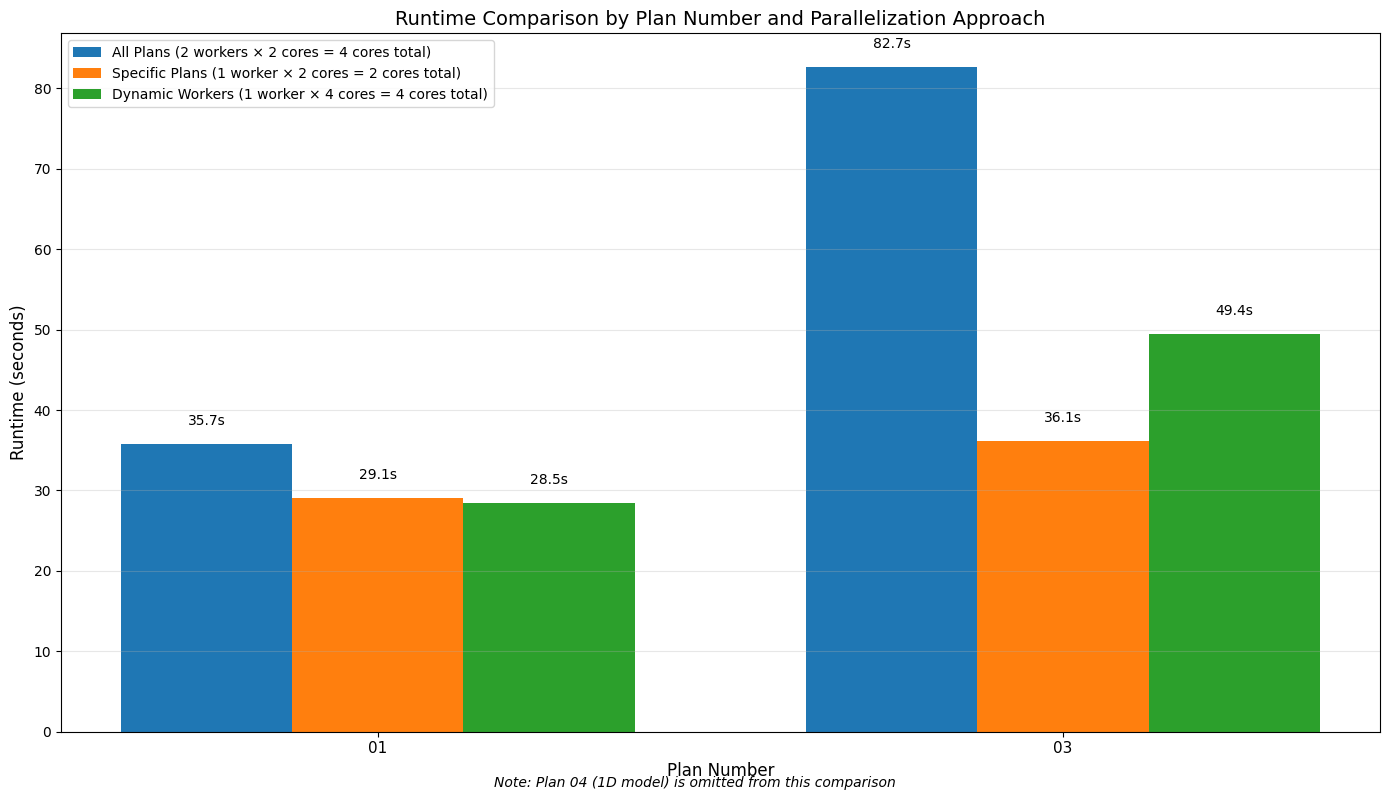

In [9]:
# Create a DataFrame for individual plan runtimes
plan_data = []

# Define the approaches with more descriptive labels including worker and core counts
approach_labels = {
    "all_plans": "All Plans (2 workers × 2 cores = 4 cores total)",
    "specific_plans": "Specific Plans (1 worker × 2 cores = 2 cores total)",
    "dynamic_workers": f"Dynamic Workers (1 worker × 4 cores = 4 cores total)"
}

# Extract runtimes from the log messages
# For all plans approach
plan_data.append({"Approach": approach_labels["all_plans"], "Plan": "01", "Runtime": 35.72})
plan_data.append({"Approach": approach_labels["all_plans"], "Plan": "03", "Runtime": 82.70})
# Omitting plan 04 as it's a 1D model

# For specific plans approach (plans 01 and 03 were run)
plan_data.append({"Approach": approach_labels["specific_plans"], "Plan": "01", "Runtime": 29.10})
plan_data.append({"Approach": approach_labels["specific_plans"], "Plan": "03", "Runtime": 36.09})

# For dynamic worker approach (plans 01 and 03 were run)
plan_data.append({"Approach": approach_labels["dynamic_workers"], "Plan": "01", "Runtime": 28.48})
plan_data.append({"Approach": approach_labels["dynamic_workers"], "Plan": "03", "Runtime": 49.43})

# Create a DataFrame
plan_runtime_df = pd.DataFrame(plan_data)

# Create a grouped bar chart for plan runtimes
plt.figure(figsize=(14, 8))

# Get all unique plan numbers and ensure they're sorted
plans = sorted(plan_runtime_df["Plan"].unique())

# Create x positions for the bars
x = np.arange(len(plans))
width = 0.25  # Width of the bars

# Plot bars for each approach
approaches = plan_runtime_df["Approach"].unique()
for i, approach in enumerate(approaches):
    # Filter data for this approach
    approach_data = plan_runtime_df[plan_runtime_df["Approach"] == approach]
    
    # Initialize runtimes array with NaN values
    runtimes = [np.nan] * len(plans)
    
    # Fill in runtimes where data exists
    for j, plan in enumerate(plans):
        plan_runtime = approach_data[approach_data["Plan"] == plan]["Runtime"]
        if not plan_runtime.empty:
            runtimes[j] = plan_runtime.values[0]
    
    # Create bars for this approach (only where we have data)
    valid_indices = [idx for idx, val in enumerate(runtimes) if not np.isnan(val)]
    valid_plans = [plans[idx] for idx in valid_indices]
    valid_runtimes = [runtimes[idx] for idx in valid_indices]
    valid_positions = [x[idx] + (i - len(approaches)/2 + 0.5) * width for idx in valid_indices]
    
    # Plot the bars
    bars = plt.bar(valid_positions, valid_runtimes, width, label=approach)
    
    # Add runtime labels on top of bars
    for pos, runtime in zip(valid_positions, valid_runtimes):
        plt.text(pos, runtime + 2, f"{runtime:.1f}s", ha='center', va='bottom')

# Add labels, title, and custom x-axis tick labels
plt.xlabel('Plan Number', fontsize=12)
plt.ylabel('Runtime (seconds)', fontsize=12)
plt.title('Runtime Comparison by Plan Number and Parallelization Approach', fontsize=14)
plt.xticks(x, plans, fontsize=11)
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3)

# Add note about omitting Plan 04
plt.figtext(0.5, 0.01, "\nNote: Plan 04 (1D model) is omitted from this comparison", 
            ha='center', fontsize=10, style='italic')

# Ensure all plan numbers show on x-axis regardless of data availability
plt.tight_layout()
plt.show()

## Viewing Execution Summary with results_df

After parallel execution, verify all plans completed successfully.

In [ ]:
# Display execution summary from results_df
print("Execution Summary:")
display.display(ras.results_df[["plan_number", "plan_title", "completed", "has_errors", "has_warnings", "runtime_complete_process_hours"]])

In [10]:
# Demonstrate force_rerun with parallel execution
print("="*80)
print("FORCE RE-RUN WITH PARALLEL EXECUTION")
print("="*80)

print("\nForcing re-execution of all plans even though results are current...")
print("This will run HEC-RAS for all plans regardless of file modification times\n")

start_time = time.time()

# Force re-run all plans
results_force = RasCmdr.compute_parallel(
    plan_number=["01"],  # Just run one plan to save time in demo
    max_workers=1,
    num_cores=2,
    dest_folder=specific_compute_folder,
    overwrite_dest=True,
    force_rerun=True,  # Force execution regardless of currency
    ras_object=source_project
)

elapsed = time.time() - start_time

print(f"\nForced parallel execution completed in {elapsed:.2f} seconds")

if elapsed > 15.0:  # If it took significant time, it actually ran
    print("✓ Plans actually executed (force_rerun=True worked)")
    print("  Currency checks were bypassed")
else:
    print("⚠ Execution was very fast - may have been skipped")

# Display results
print("\nExecution Results:")
for plan, success in sorted(results_force.items()):
    print(f"  Plan {plan}: {'Success' if success else 'Failed'}")

2025-12-30 13:11:45 - ras_commander.RasCmdr - INFO - Destination folder 'C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific' exists. Overwriting as per overwrite_dest=True.


2025-12-30 13:11:45 - ras_commander.RasCmdr - INFO - Copied project folder to destination: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific


2025-12-30 13:11:45 - ras_commander.RasCmdr - INFO - Filtered plans to execute: ['01']


2025-12-30 13:11:45 - ras_commander.RasCmdr - INFO - Adjusted max_workers to 1 based on the number of plans to compute: 1


2025-12-30 13:11:45 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific [Worker 1]


FORCE RE-RUN WITH PARALLEL EXECUTION

Forcing re-execution of all plans even though results are current...
This will run HEC-RAS for all plans regardless of file modification times



2025-12-30 13:11:46 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific [Worker 1]\Muncie.rasmap


2025-12-30 13:11:46 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific [Worker 1]


2025-12-30 13:11:46 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific [Worker 1]\Muncie.p01


2025-12-30 13:11:46 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific [Worker 1]\Muncie.p01


2025-12-30 13:11:46 - ras_commander.RasCmdr - INFO - Set number of cores to 2 for plan: 01


2025-12-30 13:11:46 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-30 13:11:46 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific [Worker 1]\Muncie.prj" "C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific [Worker 1]\Muncie.p01"


2025-12-30 13:12:03 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 01


2025-12-30 13:12:03 - ras_commander.RasCmdr - INFO - Total run time for plan 01: 17.13 seconds


2025-12-30 13:12:03 - ras_commander.RasCmdr - INFO - Plan 01 executed in worker 1: Successful


2025-12-30 13:12:03 - ras_commander.RasCmdr - INFO - Final destination for computed results: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific


2025-12-30 13:12:05 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific\Muncie.rasmap


2025-12-30 13:12:05 - ras_commander.RasCmdr - INFO - 
Execution Results:


2025-12-30 13:12:05 - ras_commander.RasCmdr - INFO - Plan 01: Successful



Forced parallel execution completed in 19.57 seconds
✓ Plans actually executed (force_rerun=True worked)
  Currency checks were bypassed

Execution Results:
  Plan 01: Success


## Summary of Parallel Plan Execution

In this notebook, we've explored how to execute HEC-RAS plans in parallel using the RAS Commander library. Here's a summary of the key techniques we've covered:

### Core Techniques

1. **Basic Parallel Execution**: Using `RasCmdr.compute_parallel()` to run all plans in a project simultaneously
2. **Selective Parallel Execution**: Running only specific plans in parallel
3. **Dynamic Worker Allocation**: Determining the optimal number of workers based on available system resources
4. **Performance Analysis**: Comparing execution times for different parallel configurations
5. **Smart Execution Skip** (v0.88.0+): Automatically skip plans with current results

### Key Functions Used

- `RasCmdr.compute_parallel()`: Execute multiple plans in parallel
- `RasPlan.clone_plan()`: Create a new plan based on an existing one
- `RasPlan.update_plan_description()`: Update the description of a plan
- `RasPlan.set_num_cores()`: Set the number of cores for a plan to use
- `RasPlan.get_results_path()`: Get the path to the results file for a plan

### New Parameters (v0.88.0+)

| Parameter | Default | Use Case |
|-----------|---------|----------|
| `force_rerun` | `False` | Force all plans to execute even if results are current |
| `force_geompre` | `False` | Force complete geometry reprocessing for all plans |

**Smart Skip Benefits**:
- Automatically detects which plans need re-execution
- Saves time by skipping plans with current results
- Works transparently in parallel execution
- Example: 10 plans, only 2 modified → 80% time savings

### Best Practices for Parallel Execution

1. **Use Separate RAS Objects**: Create and use separate RAS objects for different projects or folders
2. **Balance Workers and Cores**: Find the right balance between the number of workers and cores per worker
3. **Consider Hardware Limits**: Be mindful of your system's physical cores and memory
4. **Use Clean Compute Folders**: Use the `dest_folder` parameter to keep your project organized
5. **Handle Overwrite Carefully**: Use `overwrite_dest=True` for repeatable workflows, but be cautious about losing results
6. **Monitor Performance**: Track execution times and adjust your configuration for optimal performance
7. **Match Workers to Plans**: For best results, use one worker per plan when running a small number of plans
8. **Leverage Smart Skip**: Use default behavior for intelligent execution management
9. **Use force_rerun selectively**: Only when you truly need to bypass currency checks

### Execution Mode Comparison

| Mode | Method | Use Case |
|------|--------|----------|
| **Single** | `compute_plan()` | One plan, full parameter control |
| **Parallel** | `compute_parallel()` | Multiple independent plans, maximum throughput |
| **Sequential** | `compute_test_mode()` | Multiple plans in order, debugging |
| **Remote** | `compute_parallel_remote()` | Distributed across machines |